# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Read Wind Energy Production Dataset

In [2]:
data = pd.read_csv('F:\APU\FYP\Dataset\Cleaned_data\wind_production_dataset.csv')

data.head()

,Country,Date,Value,Wind10int,Wind100int
0,Australia,2023-03-01,2415.8842,3.689722,5.550105
1,Australia,2023-02-01,2540.7584,3.966472,5.909515
2,Australia,2023-01-01,2614.8241,4.017246,5.866050
3,Australia,2022-12-01,2690.1965,4.128255,6.038626
4,Australia,2022-11-01,2510.9518,4.213749,6.209358


## Extract Data for each country

In [3]:
countries = data['Country'].unique()

wind_production_data = {}

# use loc() function to select data from a DataFrame based on specified row and column labels or conditions.
# Iterate over the countries
for country in countries:
    # Filter the data for the current country and 'wind' product
    country_energy_production = data.loc[
        (data['Country'] == country), ['Date', 'Value', 'Wind10int', 'Wind100int']
    ]
    
    # Store the filtered data in the dictionary
    wind_production_data[country] = country_energy_production.reset_index(drop=True)

wind_production_data['Canada']

,Date,Value,Wind10int,Wind100int
0,2023-03-01,3418.7062,3.438499,5.346673
1,2023-02-01,3914.9501,3.647899,5.816089
2,2023-01-01,3206.4003,3.497332,5.614251
3,2022-12-01,3759.2633,3.989855,6.385566
4,2022-11-01,4122.9702,3.991582,6.295511
...,...,...,...,...
154,2010-05-01,674.5330,3.704682,5.524492
155,2010-04-01,725.9510,3.957156,6.126607
156,2010-03-01,667.4480,3.781871,5.945501
157,2010-02-01,453.2080,3.525456,5.629358


# Resample to daily data

In [4]:
for country_data in wind_production_data:
    
    # set time as the index
    wind_production_data[country_data]['Date'] = pd.to_datetime(wind_production_data[country_data]['Date'])
    wind_production_data[country_data].set_index('Date', inplace=True)
    
    # divide the monthly statistical production value by the number of days 
    # of the month to get the avarage daily production value
    wind_production_data[country_data]['Value'] = (wind_production_data[country_data]['Value']/
                                                    wind_production_data[country_data].index.days_in_month)
    
    # resample the monthly index to daily and impute the missing value with linear interpolate method
    daily_data = wind_production_data[country_data].resample('D').interpolate('linear')
    wind_production_data[country_data] = daily_data
    
wind_production_data['Canada']

,Value,Wind10int,Wind100int
Date,,,
2010-01-01,20.367935,3.962832,6.346178
2010-01-02,20.233034,3.948723,6.323055
2010-01-03,20.098133,3.934614,6.299932
2010-01-04,19.963232,3.920505,6.276808
2010-01-05,19.828331,3.906396,6.253685
...,...,...,...
2023-02-25,114.500674,3.468414,5.413733
2023-02-26,113.445717,3.460935,5.396968
2023-02-27,112.390760,3.453456,5.380203


# Model Building

### Split train and test data

In [5]:
data = wind_production_data['Canada']

# Split the data into training and testing sets
split_date = '2021-01-01'
train, test = data[:split_date], data[split_date:]

print(train.head())
print(train.shape)
print()
print(test.head())
print(test.shape)

                Value  Wind10int  Wind100int
Date                                        
2010-01-01  20.367935   3.962832    6.346178
2010-01-02  20.233034   3.948723    6.323055
2010-01-03  20.098133   3.934614    6.299932
2010-01-04  19.963232   3.920505    6.276808
2010-01-05  19.828331   3.906396    6.253685
(4019, 3)

                Value  Wind10int  Wind100int
Date                                        
2021-01-01  91.841048   3.475318    5.619133
2021-01-02  92.303379   3.486511    5.632998
2021-01-03  92.765709   3.497705    5.646864
2021-01-04  93.228039   3.508898    5.660729
2021-01-05  93.690370   3.520092    5.674594
(790, 3)


## Univariate Model - ARIMA - Daily

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

#### The developer has use R with the auto.arima() function to identify the p, q, d value of the best fit ARIMA model for this dataset, the result shows that the order(p, q, d) = (1,1,0)(0,1,0)[365] 

#### Figure below show the result from R:
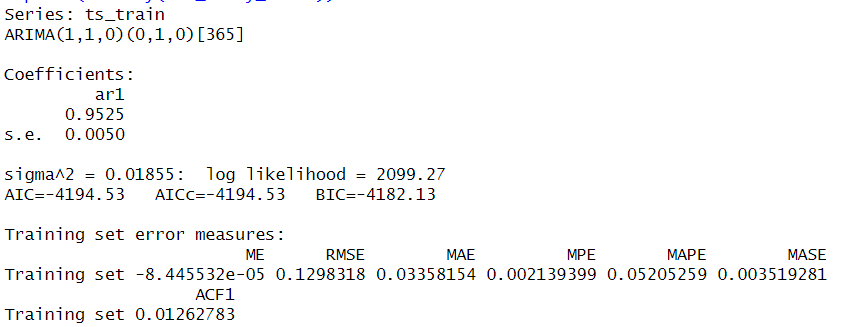

In [60]:
import rpy2.robjects as robjects
# Load the 'forecast' R package
robjects.r("library(forecast)")

# Load the ARIMA model
r_load = robjects.r['readRDS']
can_wind_arima_model = r_load(r"F:\APU\FYP\SEM 2\Report Doc\R script\can_wind_arima_model.rds")

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package 'forecast' was built under R version 4.1.3 



In [62]:
# Generate predictions
r_forecast = robjects.r['forecast']
predictions = r_forecast(can_wind_arima_model, h=len(test))

# Evaluate the model performance
print("Mean Absolute Error: ", mean_absolute_error(predictions.rx('mean')[0], test['Value'].values))
mse = mean_squared_error(predictions.rx('mean')[0], test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  13.952569932449231
Mean Squared Error:  306.62274532418496
Root Mean Squared Error:  17.510646627814317


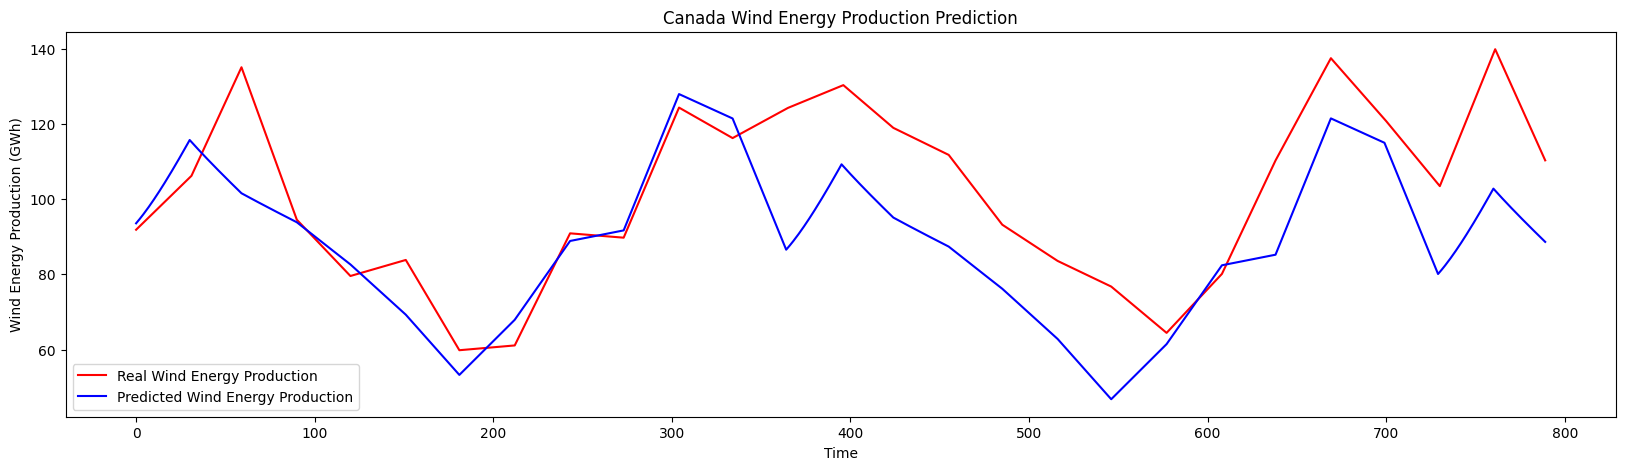

In [63]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(predictions.rx('mean')[0], color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('Canada Wind Energy Production Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy Production (GWh)')
plt.legend()
plt.show()

## XGBoost - Univariate

In [64]:
def create_features(df, label=None):

    #Creates time series features from datetime index
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype('int64')
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [65]:
X_train, y_train = create_features(train.copy(), label='Value')
X_test, y_test = create_features(test.copy(), label='Value')

print(X_train.head())
print(X_train.shape)
print()
print(y_train.head())
print(y_train.shape)
print()
print(X_test.head())
print(X_test.shape)
print()
print(y_test.head())
print(y_test.shape)

            dayofweek  quarter  month  year  dayofyear  dayofmonth  weekofyear
Date                                                                          
2010-01-01          4        1      1  2010          1           1          53
2010-01-02          5        1      1  2010          2           2          53
2010-01-03          6        1      1  2010          3           3          53
2010-01-04          0        1      1  2010          4           4           1
2010-01-05          1        1      1  2010          5           5           1
(4019, 7)

Date
2010-01-01    20.367935
2010-01-02    20.233034
2010-01-03    20.098133
2010-01-04    19.963232
2010-01-05    19.828331
Freq: D, Name: Value, dtype: float64
(4019,)

            dayofweek  quarter  month  year  dayofyear  dayofmonth  weekofyear
Date                                                                          
2021-01-01          4        1      1  2021          1           1          53
2021-01-02          5       

In [15]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [16]:
can_daily_xgb = xgb.XGBRegressor(n_estimators=1000)
can_daily_xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=True)

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:50.30760	validation_1-rmse:75.50650
[1]	validation_0-rmse:35.53807	validation_1-rmse:54.49912
[2]	validation_0-rmse:25.16708	validation_1-rmse:39.85214
[3]	validation_0-rmse:17.90767	validation_1-rmse:29.99412
[4]	validation_0-rmse:12.82684	validation_1-rmse:22.95910
[5]	validation_0-rmse:9.31417	validation_1-rmse:18.32179
[6]	validation_0-rmse:6.87376	validation_1-rmse:15.46037
[7]	validation_0-rmse:5.21914	validation_1-rmse:13.49346
[8]	validation_0-rmse:4.11172	validation_1-rmse:12.87621
[9]	validation_0-rmse:3.30862	validation_1-rmse:12.06542
[10]	validation_0-rmse:2.78711	validation_1-rmse:11.62242
[11]	validation_0-rmse:2.42520	validation_1-rmse:11.33519
[12]	validation_0-rmse:2.15634	validation_1-rmse:11.17517
[13]	validation_0-rmse:1.91743	validation_1-rmse:10.98248
[14]	validation_0-rmse:1.74091	validation_1-rmse:10.95194
[15]	validation_0-rmse:1.63542	validation_1-rmse:10.89324
[16]	validation_0-rmse:1.57349	validation_1-rmse:10.84580
[17]	validation_0-r

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

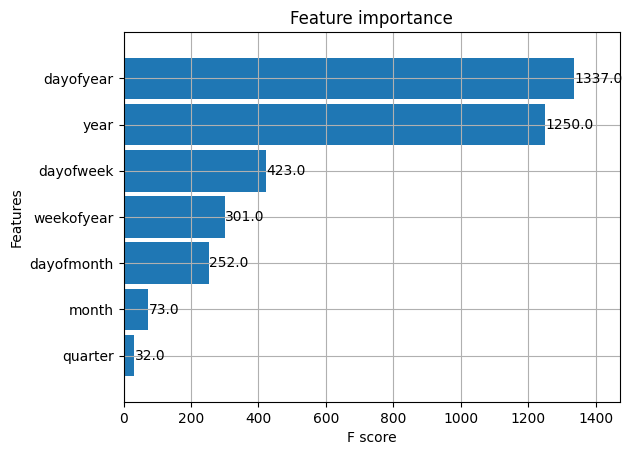

In [17]:
_ = plot_importance(can_daily_xgb, height=0.9)

In [66]:
xgb_y_pred = can_daily_xgb.predict(X_test)

In [67]:
print("Mean Absolute Error: ", mean_absolute_error(xgb_y_pred, test['Value'].values))
mse = mean_squared_error(xgb_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  8.94937162268267
Mean Squared Error:  117.19121364950688
Root Mean Squared Error:  10.825489072069995


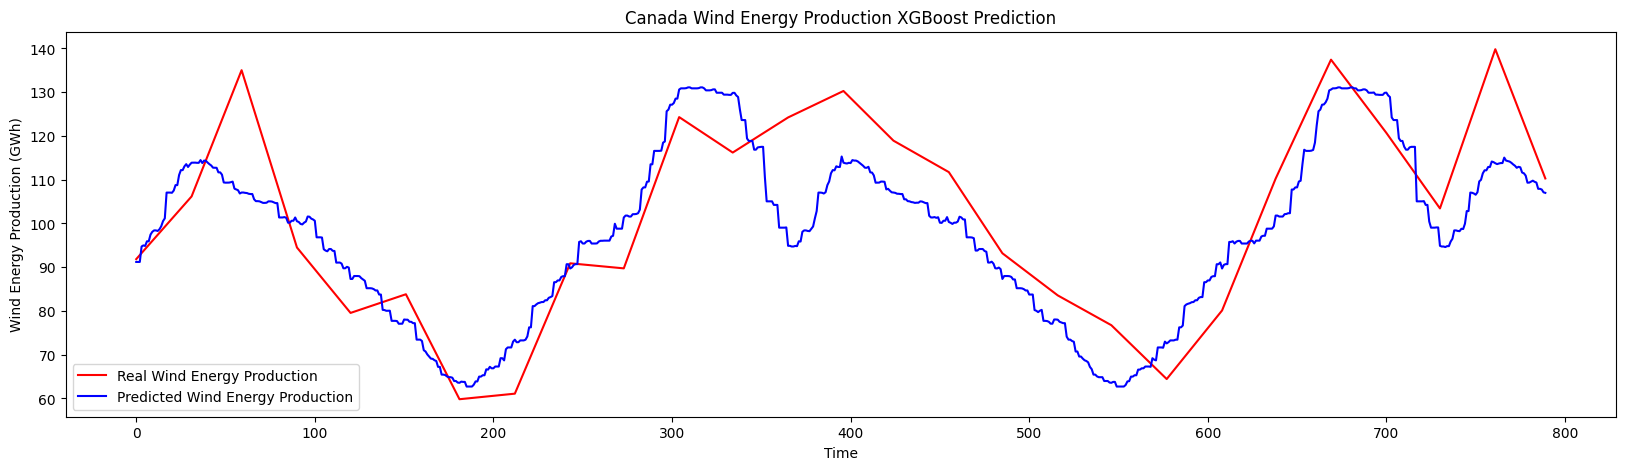

In [68]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(xgb_y_pred, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('Canada Wind Energy Production XGBoost Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy Production (GWh)')
plt.legend()
plt.show()

## SVM - Univariate

In [21]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [69]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Value']].values)
test_scaled = scaler.transform(test[['Value']].values)

# Reshape the input data
time_steps = 365  # Define the number of previoCanada time steps to consider

# Creating a data structure with 365 timestamps and 1 output
x_train = []
y_train = []
for i in range(time_steps, len(train)):
    x_train.append(train_scaled[i-time_steps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)

(3654, 365) (3654,)


In [70]:
# Build and Train the SVM Model
can_daily_svr = SVR(kernel='linear',gamma=0.5, C=10, epsilon = 0.01) # Specify hyperparameters
can_daily_svr.fit(x_train, y_train)

SVR(C=10, epsilon=0.01, gamma=0.5, kernel='linear')

In [71]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(time_steps, len(test)+time_steps):
    x_test.append(inputs[i-time_steps:i, 0])
x_test = np.array(x_test)

# Predict Wind Energy Production
svr_y_pred = can_daily_svr.predict(x_test).reshape(-1,1)
svr_y_pred = scaler.inverse_transform(svr_y_pred)
print(svr_y_pred.shape)

(790, 1)


In [72]:
# Evaluate the model
print("Mean Absolute Error: ", mean_absolute_error(svr_y_pred, test['Value'].values))
mse = mean_squared_error(svr_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  0.6722401884677653
Mean Squared Error:  0.6687813770556075
Root Mean Squared Error:  0.8177905459563637


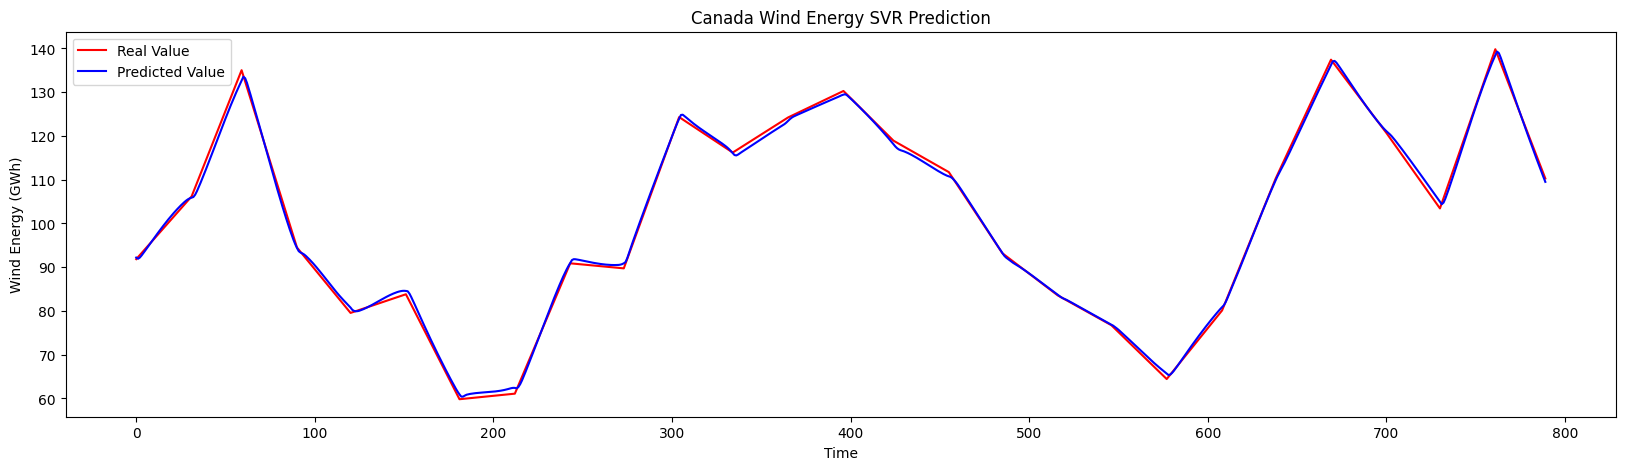

In [73]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color='red', label='Real Value')
plt.plot(svr_y_pred, color='blue', label='Predicted Value')
plt.title('Canada Wind Energy SVR Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Univariate GRU - Daily

In [80]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

In [81]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Set the number of time steps (input sequence length)
time_steps = 365

# Create the training datasets
X_train, y_train = create_dataset(training_set_scaled, time_steps)

# Create the testing datasets
X_test, y_test = create_dataset(test['Value'].values, time_steps)

In [82]:
from keras.models import Sequential
from keras.layers import GRU, Dense

# Create the model
can_daily_gru = Sequential()
can_daily_gru.add(GRU(units=64, return_sequences=True, input_shape=(time_steps, 1)))
can_daily_gru.add(GRU(units=64, input_shape=(time_steps, 1)))
can_daily_gru.add(Dense(1, activation='linear'))

can_daily_gru.compile(optimizer='adam', loss='mean_squared_error')

In [83]:
can_daily_gru.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
115/115 [==============================] - 79s 230ms/step - loss: 0.0131
Epoch 2/100
115/115 [==============================] - 25s 217ms/step - loss: 1.5294e-04
Epoch 3/100
115/115 [==============================] - 26s 224ms/step - loss: 1.1832e-04
Epoch 4/100
115/115 [==============================] - 25s 219ms/step - loss: 9.4928e-05
Epoch 5/100
115/115 [==============================] - 25s 217ms/step - loss: 7.8707e-05
Epoch 6/100
115/115 [==============================] - 25s 221ms/step - loss: 7.2187e-05
Epoch 7/100
115/115 [==============================] - 25s 214ms/step - loss: 6.0554e-05
Epoch 8/100
115/115 [==============================] - 26s 223ms/step - loss: 5.3391e-05
Epoch 9/100
115/115 [==============================] - 27s 234ms/step - loss: 4.5423e-05
Epoch 10/100
115/115 [==============================] - 27s 231ms/step - loss: 3.5831e-05
Epoch 11/100
115/115 [==============================] - 27s 233ms/step - loss: 2.4834e-05
Epoch 12/100
115/115 [=

In [84]:
# Getting the predicted value
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
X_test = np.array(X_test)

gru_y_pred = can_daily_gru.predict(X_test)
gru_y_pred = sc.inverse_transform(gru_y_pred)

25/25 [==============================] - 16s 74ms/step


In [85]:
print("Mean Absolute Error: ", mean_absolute_error(gru_y_pred, test['Value'].values))
mse = mean_squared_error(gru_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  0.33770704707787785
Mean Squared Error:  0.15036486472568036
Root Mean Squared Error:  0.3877690868618595


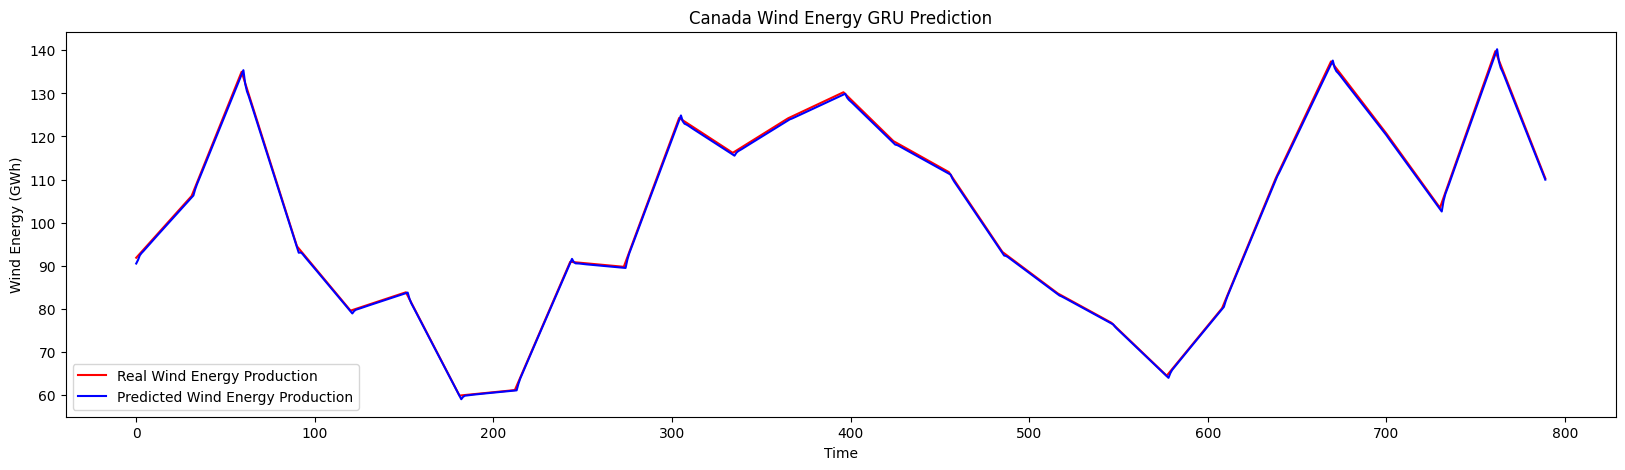

In [86]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(gru_y_pred, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('Canada Wind Energy GRU Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Univariate LSTM - Daily

In [87]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

print(training_set_scaled)
print(training_set_scaled.shape)

[[0.03538802]
 [0.03424647]
 [0.03310492]
 ...
 [0.65987461]
 [0.65003818]
 [0.64020175]]
(4019, 1)


In [88]:
# Creating a data structure with 365 timestamps and 1 output
X_train = []
y_train = []
for i in range(time_steps, len(train)):
    X_train.append(training_set_scaled[i-time_steps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [89]:
print(X_train)
X_train.shape

[[0.03538802 0.03424647 0.03310492 ... 0.07892101 0.07673522 0.07454943]
 [0.03424647 0.03310492 0.03196337 ... 0.07673522 0.07454943 0.07236364]
 [0.03310492 0.03196337 0.03082182 ... 0.07454943 0.07236364 0.07451333]
 ...
 [0.64088766 0.63455299 0.64250887 ... 0.68938389 0.67954747 0.66971104]
 [0.63455299 0.64250887 0.65046475 ... 0.67954747 0.66971104 0.65987461]
 [0.64250887 0.65046475 0.65842063 ... 0.66971104 0.65987461 0.65003818]]


(3654, 365)

In [90]:
print(y_train)
y_train.shape

[0.07236364 0.07451333 0.07666301 ... 0.65987461 0.65003818 0.64020175]


(3654,)

In [91]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [39]:
# Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [40]:
# Initialising the RNN
can_daily_uni_lstm = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
can_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
can_daily_uni_lstm.add(Dropout(0.2))

can_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True))
can_daily_uni_lstm.add(Dropout(0.2))

can_daily_uni_lstm.add(LSTM(units = 64))
can_daily_uni_lstm.add(Dropout(0.2))

# Adding the output layer
can_daily_uni_lstm.add(Dense(units = 1))

In [41]:
# Compiling the RNN
can_daily_uni_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
can_daily_uni_lstm.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
115/115 [==============================] - 196s 941ms/step - loss: 0.0110
Epoch 2/100
115/115 [==============================] - 107s 929ms/step - loss: 0.0031
Epoch 3/100
115/115 [==============================] - 108s 936ms/step - loss: 0.0027
Epoch 4/100
115/115 [==============================] - 107s 928ms/step - loss: 0.0023
Epoch 5/100
115/115 [==============================] - 106s 923ms/step - loss: 0.0022
Epoch 6/100
115/115 [==============================] - 103s 898ms/step - loss: 0.0018
Epoch 7/100
115/115 [==============================] - 102s 888ms/step - loss: 0.0015
Epoch 8/100
115/115 [==============================] - 104s 902ms/step - loss: 0.0014
Epoch 9/100
115/115 [==============================] - 106s 922ms/step - loss: 0.0016
Epoch 10/100
115/115 [==============================] - 105s 910ms/step - loss: 0.0013
Epoch 11/100
115/115 [==============================] - 96s 832ms/step - loss: 0.0013
Epoch 12/100
115/115 [==============================]

In [42]:
test[['Value']].shape

(790, 1)

In [92]:
# Getting the predicted stock price of 2017
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
uni_lstm_y_pred = can_daily_uni_lstm.predict(X_test)
uni_lstm_y_pred = sc.inverse_transform(uni_lstm_y_pred)

25/25 [==============================] - 9s 116ms/step


In [93]:
print("Mean Absolute Error: ", mean_absolute_error(uni_lstm_y_pred, test['Value'].values))
mse = mean_squared_error(uni_lstm_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  1.370536137277771
Mean Squared Error:  2.487968957808521
Root Mean Squared Error:  1.57732969217235


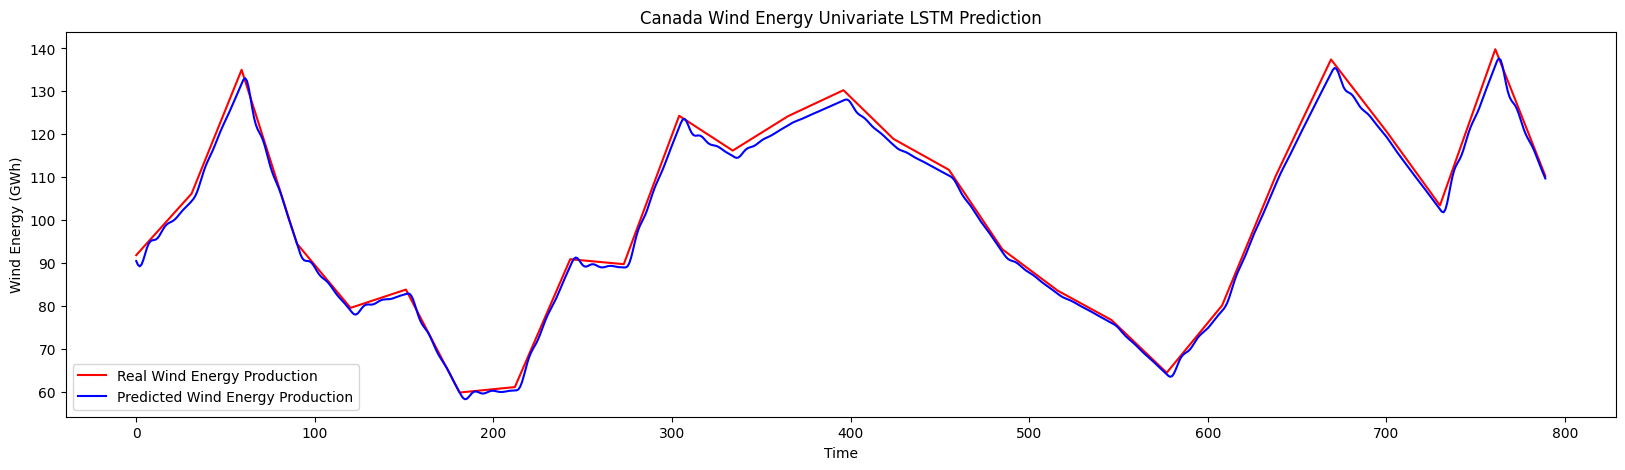

In [94]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(uni_lstm_y_pred, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('Canada Wind Energy Univariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Multivariate LSTM

In [95]:
data = wind_production_data['Canada']

data.shape

(4808, 3)

In [96]:
X = data[['Wind10int', 'Wind100int', 'Value']]
y = data[['Value']]

X.head()

,Wind10int,Wind100int,Value
Date,,,
2010-01-01,3.962832,6.346178,20.367935
2010-01-02,3.948723,6.323055,20.233034
2010-01-03,3.934614,6.299932,20.098133
2010-01-04,3.920505,6.276808,19.963232
2010-01-05,3.906396,6.253685,19.828331


In [97]:
# Split the data into training and testing sets
split_date = '2021-01-01'
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

In [98]:
# Scale the features and target variables using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = X_scaler.fit_transform(X_train), X_scaler.transform(X_test)
y_train, y_test = y_scaler.fit_transform(y_train), y_scaler.transform(y_test)

In [99]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(4019, 3)
(790, 3)

(4019, 1)
(790, 1)


In [100]:
# Reshape the input data to fit the LSTM model (samples, time steps, features)
time_steps = 365  # Define the number of previoCanada time steps to consider
n_features = X_train.shape[1]  # Number of features

# Creating a data structure with 365 timestamps and 1 output
X_train1 = []
y_train1 = []
for i in range(time_steps, len(X_train)):
    X_train1.append(X_train[i-time_steps:i])
    y_train1.append(y_train[i][0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

print(X_train1.shape)

(3654, 365, 3)


In [101]:
X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], X_train1.shape[2]))

In [53]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

can_daily_multi_lstm = Sequential()
can_daily_multi_lstm.add(LSTM(units = 64, return_sequences = True, input_shape=(time_steps, n_features)))
can_daily_multi_lstm.add(Dropout(0.2))
can_daily_multi_lstm.add(LSTM(units = 64, activation = 'relu', return_sequences = True))
can_daily_multi_lstm.add(Dropout(0.2))
can_daily_multi_lstm.add(LSTM(units = 64))
can_daily_multi_lstm.add(Dropout(0.2))
can_daily_multi_lstm.add(Dense(1))

In [54]:
can_daily_multi_lstm.compile(optimizer='adam', loss='mean_squared_error')

can_daily_multi_lstm.fit(X_train1, y_train1, epochs=100, batch_size=32)

Epoch 1/100
115/115 [==============================] - 151s 654ms/step - loss: 0.0127
Epoch 2/100
115/115 [==============================] - 83s 718ms/step - loss: 0.0036
Epoch 3/100
115/115 [==============================] - 81s 704ms/step - loss: 0.0026
Epoch 4/100
115/115 [==============================] - 77s 669ms/step - loss: 0.0024
Epoch 5/100
115/115 [==============================] - 79s 687ms/step - loss: 0.0023
Epoch 6/100
115/115 [==============================] - 80s 695ms/step - loss: 0.0022
Epoch 7/100
115/115 [==============================] - 87s 754ms/step - loss: 0.0018
Epoch 8/100
115/115 [==============================] - 79s 682ms/step - loss: 0.0016
Epoch 9/100
115/115 [==============================] - 86s 749ms/step - loss: 0.0016
Epoch 10/100
115/115 [==============================] - 86s 752ms/step - loss: 0.0014
Epoch 11/100
115/115 [==============================] - 71s 616ms/step - loss: 0.0014
Epoch 12/100
115/115 [==============================] - 74s 63

In [102]:
X_total_data = X
inputs = X_total_data[len(X_total_data) - len(X_test) - 365:]
inputs = X_scaler.transform(inputs)
print(inputs.shape)
len(X_test)
X_test1 = []
for i in range(time_steps, len(X_test)+time_steps):
    X_test1.append(inputs[i-time_steps:i])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], X_test1.shape[2]))
multi_lstm_y_pred = can_daily_multi_lstm.predict(X_test1)
multi_lstm_y_pred = y_scaler.inverse_transform(multi_lstm_y_pred)
real_value = y_scaler.inverse_transform(y_test)
hist_value = y_scaler.inverse_transform(y_train)
multi_lstm_y_pred

(1155, 3)
25/25 [==============================] - 9s 129ms/step


array([[ 92.29645 ],
       [ 91.270706],
       [ 90.64266 ],
       [ 90.8258  ],
       [ 91.86272 ],
       [ 93.497025],
       [ 95.31794 ],
       [ 96.893005],
       [ 97.94357 ],
       [ 98.39871 ],
       [ 98.49917 ],
       [ 98.48273 ],
       [ 98.543594],
       [ 98.80046 ],
       [ 99.25222 ],
       [ 99.822044],
       [100.414665],
       [100.9604  ],
       [101.432076],
       [101.838165],
       [102.2042  ],
       [102.55491 ],
       [102.90434 ],
       [103.2555  ],
       [103.60571 ],
       [103.95308 ],
       [104.3     ],
       [104.65556 ],
       [105.03102 ],
       [105.430595],
       [105.85476 ],
       [106.30079 ],
       [106.76432 ],
       [107.36965 ],
       [108.19786 ],
       [109.23634 ],
       [110.462524],
       [111.784134],
       [113.09607 ],
       [114.32561 ],
       [115.449295],
       [116.48373 ],
       [117.46387 ],
       [118.42223 ],
       [119.377174],
       [120.33178 ],
       [121.27959 ],
       [122.2

In [103]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(multi_lstm_y_pred, real_value))
mse = mean_squared_error(multi_lstm_y_pred, real_value)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  0.9663141089827825
Mean Squared Error:  2.002909692112921
Root Mean Squared Error:  1.4152419199956314


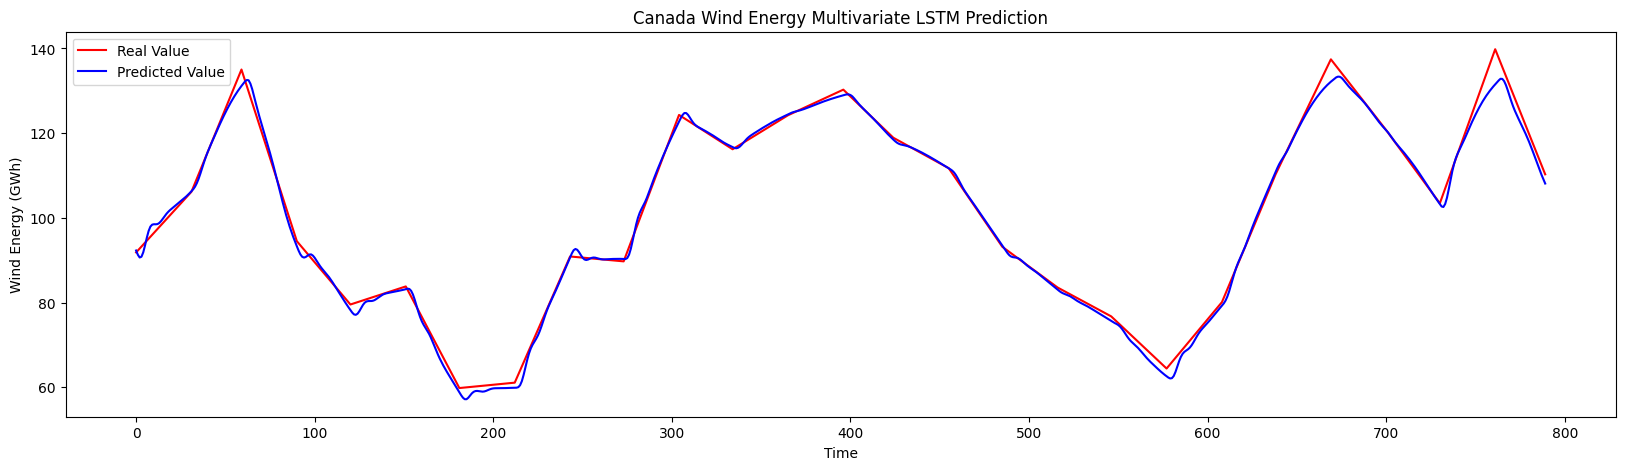

In [104]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='red', label='Real Value')
plt.plot(multi_lstm_y_pred, color='blue', label='Predicted Value')
plt.title('Canada Wind Energy Multivariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

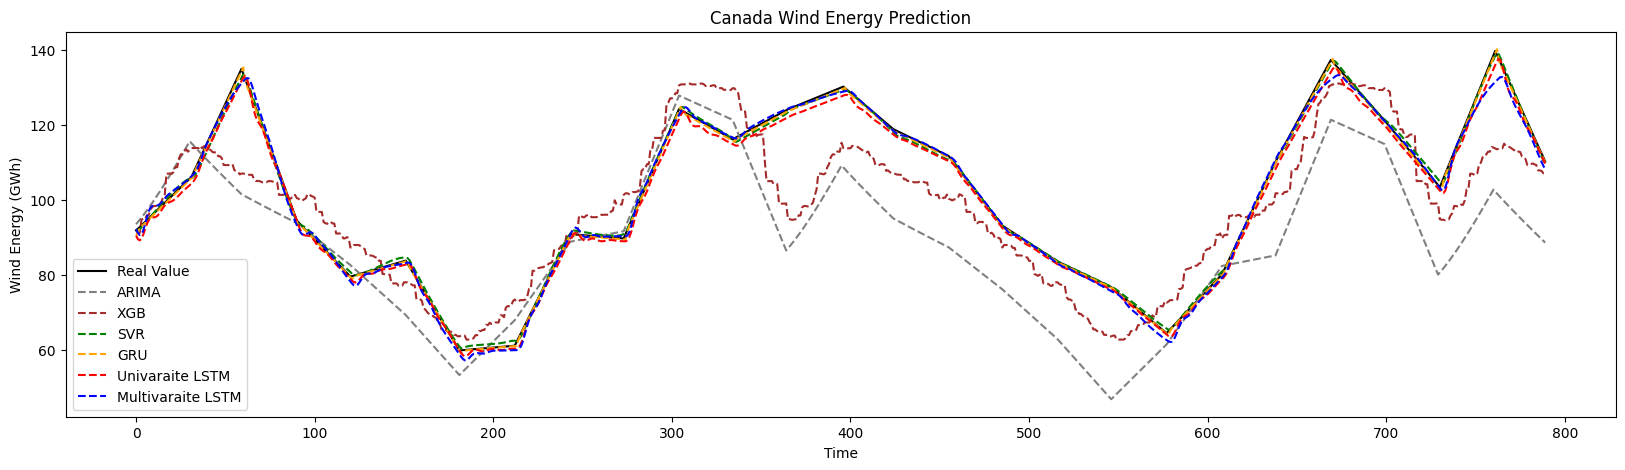

In [105]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='black', label='Real Value')
plt.plot(predictions.rx('mean')[0], color='grey', linestyle='--', label='ARIMA')
plt.plot(xgb_y_pred, color='brown', linestyle='--', label='XGB')
plt.plot(svr_y_pred, color='green', linestyle='--', label='SVR')
plt.plot(gru_y_pred, color='orange', linestyle='--', label='GRU')
plt.plot(uni_lstm_y_pred, color='red', linestyle='--', label='Univaraite LSTM')
plt.plot(multi_lstm_y_pred, color='blue', linestyle='--', label='Multivaraite LSTM')
plt.title('Canada Wind Energy Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

# Save Best Model

In [59]:
can_daily_gru.save("can_wind_best_gru.h5")

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
